In [140]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools

# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [141]:
# Read the data
df_train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')

In [142]:
# Raw data
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [143]:
print("null text = ", pd.isna(df_train['text']).sum())
print("null sentiment = ", pd.isna(df_train['sentiment']).sum())

null text =  1
null sentiment =  0


In [144]:
df_train = df_train.dropna(subset=['text'], axis=0)
print("null text = ", pd.isna(df_train['text']).sum())

null text =  0


In [145]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


# Visualizing the Data

In [146]:
temp = df_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


# Cleaning Text

In [147]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)



def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df_train['text_clean'] = df_train['text'].apply(lambda x: remove_URL(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_html(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_punct(x))

df_test['text_clean'] = df_test['text'].apply(lambda x: remove_URL(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_html(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_punct(x))

In [148]:
df_train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,Id have responded if I were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,Sons of why couldnt they put them on the rel...


In [149]:
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 27480
TEST size: 3534


________________

# Setup environment to build model

In [150]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [151]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-19 20:37:05.522607: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-19 20:37:05.522680: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}
2021-12-19 20:37:05.527932: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-19 20:37:05.528051: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}


In [152]:
# hyperparameters
max_length = 128
batch_size = 128

In [153]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Splitting the dev data

In [154]:
train, dev = train_test_split(df_train, test_size=0.1, random_state=42)

# Label Encoder

In [155]:
labels = df_train.sentiment.unique().tolist()
labels

['neutral', 'negative', 'positive']

In [156]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())
y_dev = encoder.transform(dev.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (27480, 1)
y_test (3534, 1)


In [157]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [158]:
train_encoded = bert_encode(df_train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Proposed Model

In [159]:
def bert_tweets_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]   
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(input_word_ids, outputs)
   
    
    return model

In [160]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 128, 768)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           147520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0   

In [161]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=12,
    validation_data=dev_dataset,
    verbose=1)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/12
215/215 [==============================] - 164s 380ms/step - loss: 1.0318 - accuracy: 0.4505 - val_loss: 0.5873 - val_accuracy: 0.7678
Epoch 2/12
215/215 [==============================] - 23s 105ms/step - loss: 0.6485 - accuracy: 0.7577 - val_loss: 0.4868 - val_accuracy: 0.8184
Epoch 3/12
215/215 [==============================] - 23s 106ms/step - loss: 0.5578 - accuracy: 0.7905 - val_loss: 0.4357 - val_accuracy: 0.8493
Epoch 4/12
215/215 [==============================] - 23s 106ms/step - loss: 0.5007 - accuracy: 0.8168 - val_loss: 0.3938 - val_accuracy: 0.8643
Epoch 5/12
215/215 [==============================] - 23s 106ms/step - loss: 0.4555 - accuracy: 0.8353 - val_loss: 0.3471 - val_accuracy: 0.8872
Epoch 6/12
215/215 [==============================] - 23s 106ms/step - loss: 0.4091 - accuracy: 0.8613 - val_loss: 0.2917 - val_accuracy: 0.9094
Epoch 7/12
215/215 [==============================] - 23s 106ms/step - loss: 0.3652 - accuracy: 0.8770 - val_loss: 0.2726 - val_a

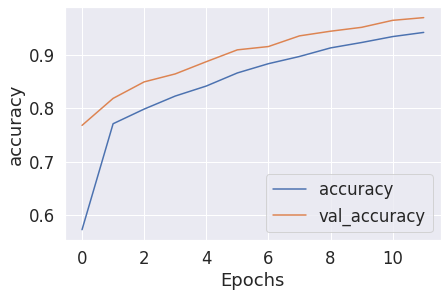

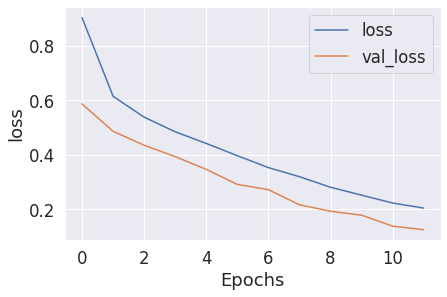

In [162]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict Manually Before Using Test Data

Decoder to be able to see results as labelled negative, positive or neutral

In [163]:
def decode_sentiment(score):
        if score == 0:
            return "negative"
        elif score == 1:
            return "neutral"
        else:
            return "positive"

In [164]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(np.argmax(score))

    return {"label": label, "score": score,
       "elapsed_time": time.time()-start_at}  

In [165]:
predict("I hate the economy")

{'label': 'negative',
 'score': array([0.993493  , 0.0049048 , 0.00160216], dtype=float32),
 'elapsed_time': 8.066713571548462}

In [166]:
predict("I would prefer writing a crawler to create this dataset but i couldn't")

{'label': 'neutral',
 'score': array([0.0350385 , 0.9473836 , 0.01757791], dtype=float32),
 'elapsed_time': 0.41671299934387207}

In [167]:
predict("I LOVE NLP")

{'label': 'positive',
 'score': array([0.00110524, 0.00332171, 0.99557304], dtype=float32),
 'elapsed_time': 0.4073493480682373}

In [168]:
predict("life is really strange isn't it? just the combination of laugh and sadness")

{'label': 'neutral',
 'score': array([0.03321305, 0.95534366, 0.01144326], dtype=float32),
 'elapsed_time': 0.42118287086486816}

In [169]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'positive',
 'score': array([0.00130574, 0.00440061, 0.9942937 ], dtype=float32),
 'elapsed_time': 0.40047287940979004}

In [170]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'positive',
 'score': array([0.0015475 , 0.00715845, 0.991294  ], dtype=float32),
 'elapsed_time': 0.41097521781921387}

In [171]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'neutral',
 'score': array([0.0192511 , 0.8361402 , 0.14460869], dtype=float32),
 'elapsed_time': 0.406325101852417}

In [172]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'negative',
 'score': array([0.6306379 , 0.34068745, 0.02867469], dtype=float32),
 'elapsed_time': 0.4156014919281006}

In [173]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'negative',
 'score': array([0.99113274, 0.0071733 , 0.00169412], dtype=float32),
 'elapsed_time': 0.4187784194946289}

In [174]:
predict("i hve no idea about that i love the uni or not")

{'label': 'neutral',
 'score': array([0.01207927, 0.85282105, 0.13509971], dtype=float32),
 'elapsed_time': 0.4134190082550049}

In [175]:
predict("Do you think Ninja's sneak up on their family members just for fun? #FunThoughts #MyBrain (@JohnLusher23)")

{'label': 'positive',
 'score': array([0.00578715, 0.20274553, 0.79146737], dtype=float32),
 'elapsed_time': 0.42020249366760254}

In [176]:
predict("So U know when u get home and see green veggie stuff\
        stuck in ur teeth and wanna curse everybody that didn't tell u (‏@tyrabanks)")

{'label': 'negative',
 'score': array([0.9919544 , 0.00648325, 0.00156235], dtype=float32),
 'elapsed_time': 0.41014790534973145}

In [177]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'positive',
 'score': array([0.02346552, 0.1522413 , 0.8242932 ], dtype=float32),
 'elapsed_time': 0.4313061237335205}

In [178]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'negative',
 'score': array([0.99045813, 0.00781059, 0.00173131], dtype=float32),
 'elapsed_time': 0.4213070869445801}

In [179]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'negative',
 'score': array([0.99173284, 0.00674187, 0.00152529], dtype=float32),
 'elapsed_time': 0.41637730598449707}

In [180]:
predict("fun fact: ai cannot predict everything right")

{'label': 'positive',
 'score': array([0.00709338, 0.2338808 , 0.75902575], dtype=float32),
 'elapsed_time': 0.4447648525238037}

In [181]:
predict("our brain is just a machine as well")

{'label': 'neutral',
 'score': array([0.00545196, 0.9904282 , 0.00411983], dtype=float32),
 'elapsed_time': 0.4278998374938965}

# Evaluate

In [182]:
test_encoded = bert_encode(df_test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [183]:
y_pred = []
for i in range(predicted_tweets.shape[0]):
    y_pred.append(np.argmax(predicted_tweets[i]))

In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1001
           1       0.74      0.74      0.74      1430
           2       0.83      0.81      0.82      1103

    accuracy                           0.78      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.78      0.78      0.78      3534

